# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Quentin Talon, Albéric de Lajarte
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Our goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).

### 1.1 Brain image visualization

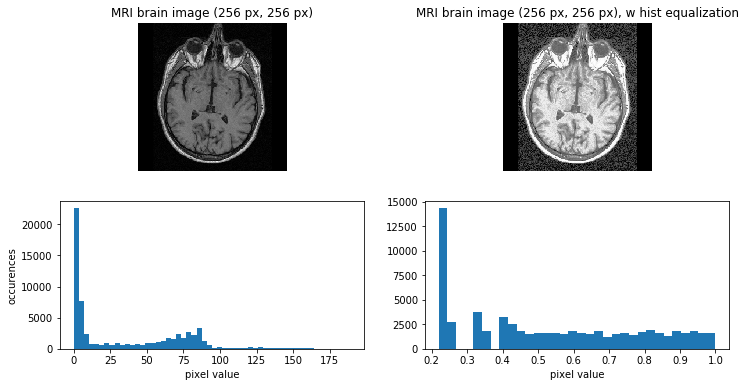

In [2]:
import skimage.io
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 6))
ax1.imshow(brain_im, cmap='gray')
ax2.imshow(exposure.equalize_hist(brain_im), cmap='gray')
ax1.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax2.set_title('MRI brain image ({} px, {} px), w hist equalization'.format(im_h, im_w))
ax1.axis('off')
ax2.axis('off')
ax3.hist(x=brain_im.ravel(), bins='auto')
ax3.set_xlabel("pixel value"); ax3.set_ylabel("occurences")
ax4.hist(x=exposure.equalize_hist(brain_im).ravel(), bins='auto')
ax4.set_xlabel("pixel value"); ax3.set_ylabel("occurences")
plt.show()

### 1.2 Region growing
We can't guess what a brain is. Thus, we want to get a region of interest **of some values**. Lets use (101, 138) coordinates to see where in the histogram we are. *(Use %matplotlib ipympl to have the coordinates shown in the notebook).*

In [3]:
print('Value at (101, 138) = {}'.format(brain_im[101,138]))

Value at (101, 138) = 67


Then, one manually select the boundaries of pixel values of what the brain might be.
We arbitarily choose to have boundaries of **60** and **95**

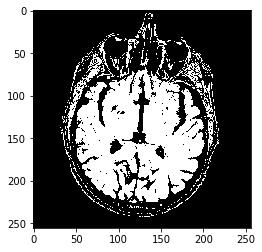

In [4]:
brain_im_bin=np.where((brain_im>60) & (brain_im<95),1,0)
plt.imshow(brain_im_bin, cmap='gray')
plt.show()

It seems to be a nice way of segmenting as the brain is clearly visible.

We implemented a simple Depth-First Search algorithm to label the brain. We manually set the seed in the brain area.

In [5]:
def DFS(G, s):
    G[s[0], s[1]] = -1
    for t in [[s[0]+i,s[1]+j] for i,j in [[1,0], [0,1], [-1,0], [0,-1]]]: #4 neighbour
        try:#Dirty way of avoiding error of out of array
            if G[t[0], t[1]] == 1:#The region have a value of 1
                DFS(G, t)
        except:
            continue

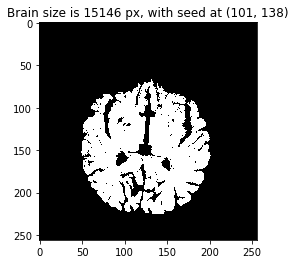

In [6]:
import sys
sys.setrecursionlimit(im_h*im_w)#To be able to go deep enough

seeds = [[101, 138]]
for s in seeds:
    brain_im_bin=np.where((brain_im>60) & (brain_im<95),1,0)#As we change the argument of explorer()
    DFS(G=brain_im_bin,s=s)
    my_brain = brain_im_bin == -1 #Have to be the value set in DFS
    size = np.count_nonzero(my_brain)#Look for True values in my_brain and count them
    plt.imshow(my_brain, cmap='gray')
    plt.title("Brain size is {} px, with seed at ({}, {})".format(size, s[0], s[1]))
    plt.show()

We see the result of our algorithm. The brain size is calculated to be **15'146 px** .

It could also be possible to map every connected surface and choose the largest one. It have been done later in this report.

### 1.3 Contour detection

### 1.4 Additional method(s)
Here we will explore different method that have shown interesting results

#### 1.4.1 Morphological transformation
We see that the brain is the largest feature on the image. One solution to isolate the brain is thus to remove small features from the image by doing a morphological opening.

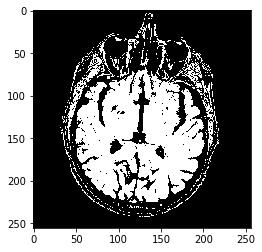

In [7]:
# Segmentation by Morphological transformation
import cv2
brain_im = cv2.imread(os.path.join(data_path, 'brain-slice40.tiff'), cv2.IMREAD_GRAYSCALE) 

brain_im_bin=np.where((brain_im>60) & (brain_im<95),1,0)
brain_im_bin = brain_im_bin.astype(np.uint8)
plt.imshow(brain_im_bin, cmap='gray')
plt.show()

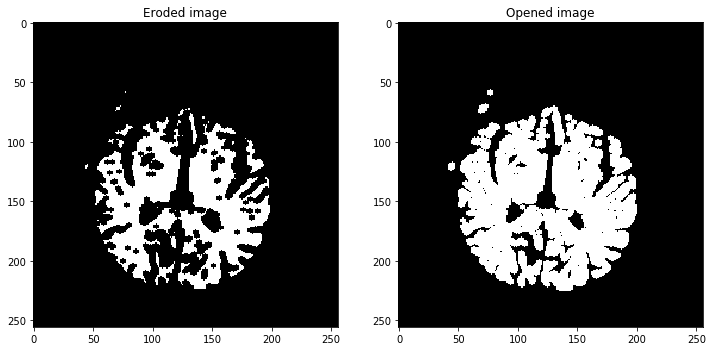

Size of brain is 14619 pixels


In [8]:
# Taking a matrix of size 5 as the kernel 
kernel = cv2.getStructuringElement( cv2.MORPH_ELLIPSE,( 5, 5 ));

# Open the image by eroding small fature and then restoring the shape by dilating
# As the brain is the only big region, bones and other tissues will be deleted
brain_erosion = cv2.erode(brain_im_bin, kernel, iterations=1) 
brain_open = cv2.dilate(brain_erosion, kernel, iterations=1) 

fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(brain_erosion, cmap='gray')
ax1.set_title("Eroded image")
ax2.imshow(brain_open, cmap='gray')
ax2.set_title("Opened image")
plt.show()

print("Size of brain is "+ str(np.count_nonzero(brain_open)) + " pixels")

We see that this method can very easily isolate the brain. However the result is less precise than other technique, as wee see that some features of the brain have been removed, and some other artefacts are still present. 

#### 1.4.2 Watersheding
As the skimage library as plenty of powerful built-in function for image processing, one can easily use them for image segmentation

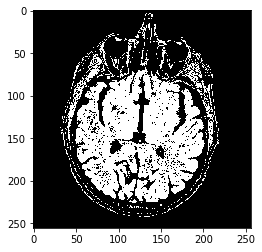

In [9]:
# Segmentation with buit in labelling function
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
brain_im_bin = np.zeros_like(brain_im)
brain_im_bin[(brain_im>60) & (brain_im<90)] = 200

plt.imshow(brain_im_bin, cmap='gray')
plt.show()

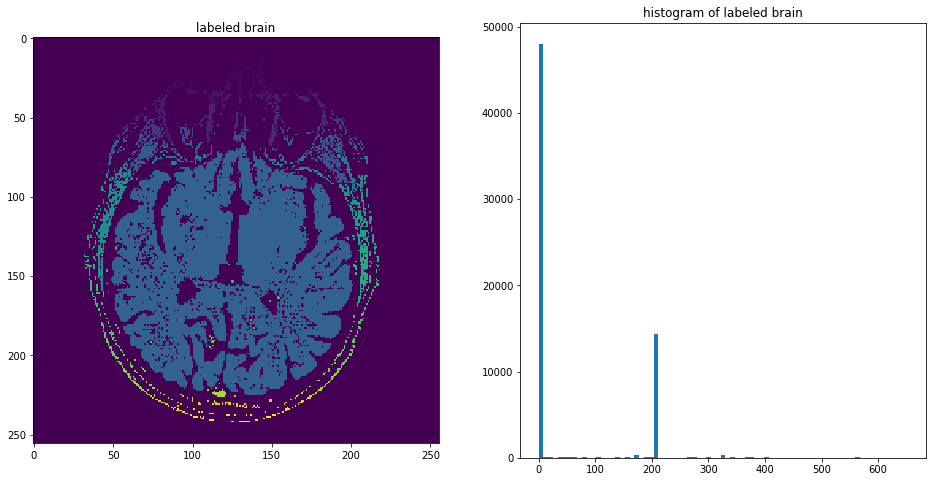

In [10]:
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.segmentation import watershed

brain_edge = ndi.gaussian_laplace(brain_im_bin, sigma=0.5).astype(np.float64)

markers = np.zeros_like(brain_edge)
markers[brain_im_bin == 0] = 1
markers[brain_im_bin == 200] = 2

# Use watershed to assign different values to different regions
segmentation = watershed(brain_edge, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1, structure=np.ones((10,10)))
labeled_brain, _ = ndi.label(segmentation)

# Plot labeled image and its histogram for segmentation
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(labeled_brain)
ax1.set_title("labeled brain")
ax2.hist(x=labeled_brain.ravel(), bins='auto')
ax2.set_title("histogram of labeled brain")

plt.show()

In [11]:
# Stable region detected as brain
label = labeled_brain[120, 150]
print(label)

206


Size of brain is 17519 pixels (22.0%)


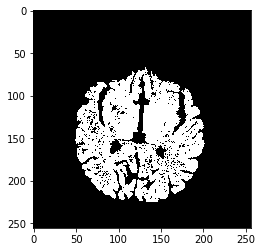

In [12]:
# We keep the region of the image which has the brain label
seg_brain = np.zeros_like(labeled_brain)
seg_brain[labeled_brain == label] = 255

seg_brain = seg_brain.astype(np.uint8)

plt.imshow(seg_brain, cmap = "gray")

ratio = 100*np.count_nonzero(seg_brain)/seg_brain.size
ratio = round(ratio*10)/10
size_brain = np.count_nonzero(labeled_brain)

print("Size of brain is " +str(size_brain) + " pixels (" + str(ratio) + "%)")

We see that the final segmented brain is really sharp, as opposed to using the morphological approach.

## Part 2: Shape/color segmentation

Here are thereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [13]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


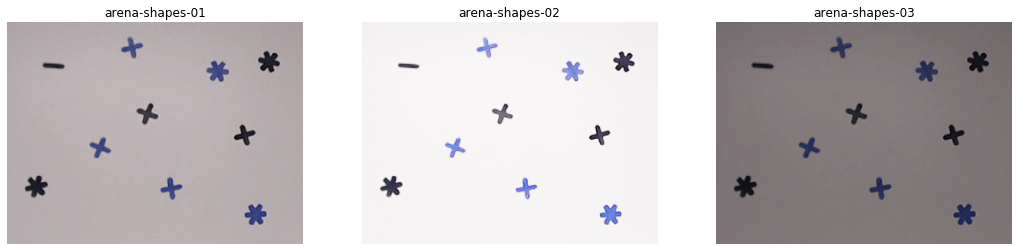

In [14]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(18, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
### Description of our algorithm
#### Segmentation of colors
We used an approach by grouping the pixels by color clusters. Every pixel have coordinates in [R, G, B] axis. The pixels agre grouped together with the k-means algorithm.

#### Number of different colors
We have chosen to fix $K=3$ here in the code as we have only 3 colors to match. If the "real" problem is kept with a known number of color, this is the best choice. Otherwhise it is possible to search the right number of colors. This finding of number of colors would be less robust than giving a fixed value.

#### Objects detection
To know how many objects of a color we have, we've chosen to do the following :

We do a binary opening by a shape of 5x5 to remove the small bits of colors from diferenciation.
We do a binary dilatation to glue back the shapes that have been separated in different regions due to small parts assigned to an other color.
Finally, we label every region and count how many labels we have.
#### Total area of each color
This part is simply a count of elements in a color.

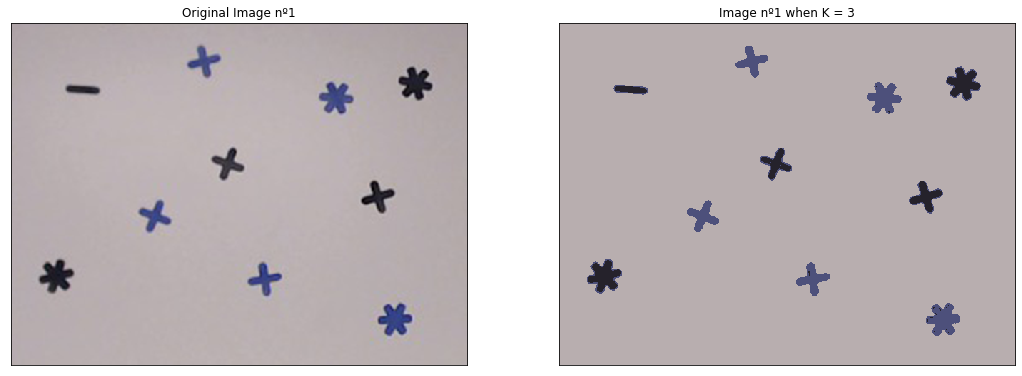

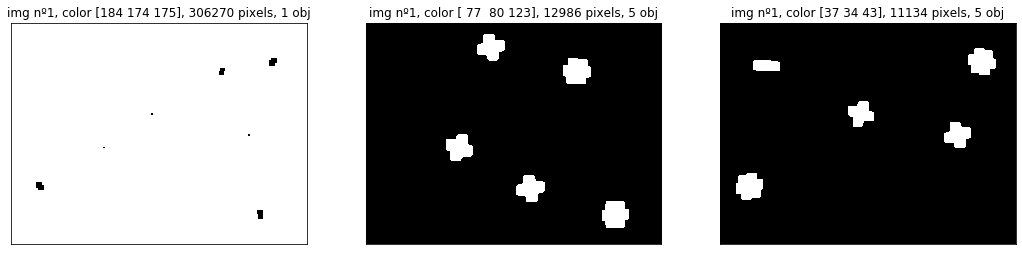

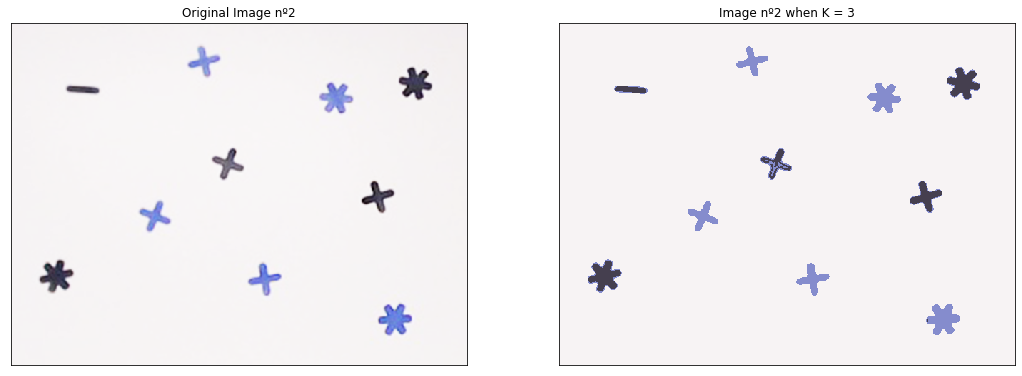

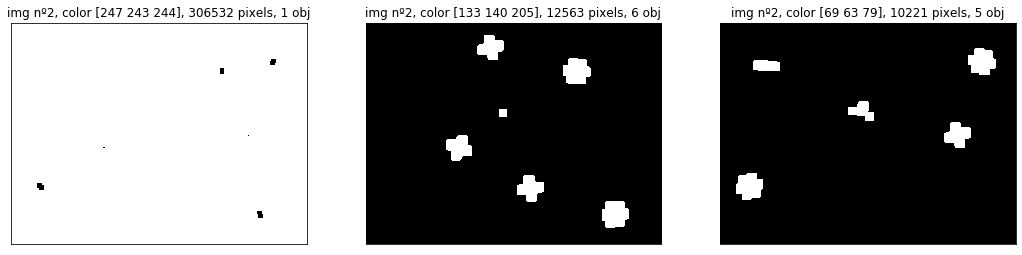

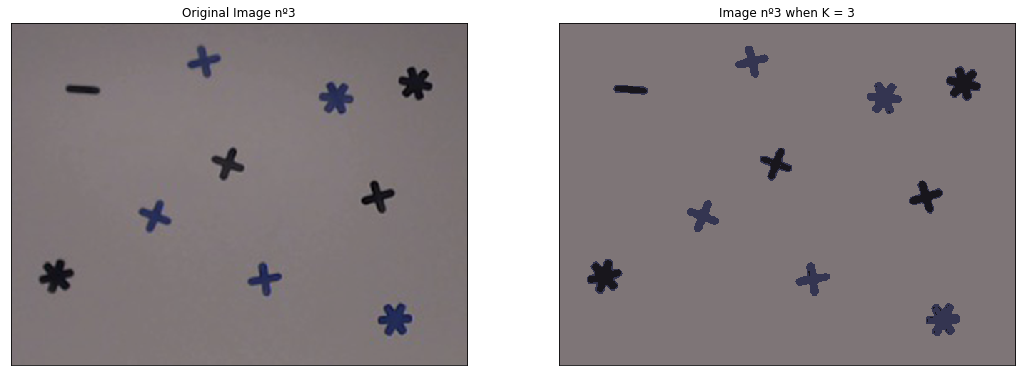

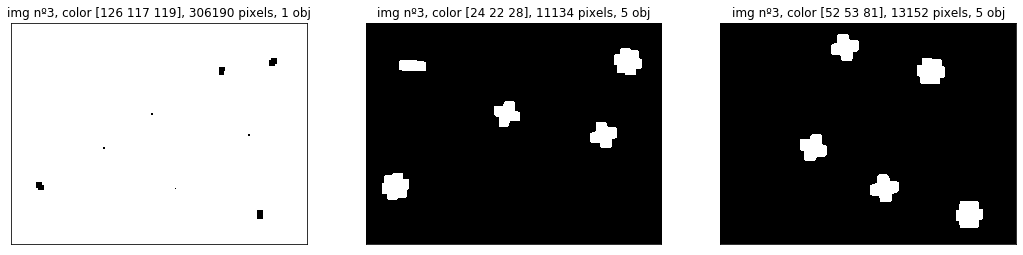

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import cv2
import scipy.ndimage.morphology as morph
from skimage.measure import label, regionprops

#img = images[0]
K = 3 #
for i, img_original in enumerate(images):
    img = img_original
    #img = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    #img = cv2.cvtColor(img_original, cv2.COLOR_BGR2YUV)#One can try different vision
    if False:
        r, g, b = cv2.split(img)
        r = r.flatten()
        g = g.flatten()
        b = b.flatten()
        #plotting
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(r, g, b)
        plt.show()
    #----------
    vectorized = np.float32(img.reshape((-1,3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts=10
    ret,labels,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[labels.flatten()]
    result_image = res.reshape((img.shape))
    #-------------
    figure_size = 18
    plt.figure(figsize=(figure_size,figure_size))#Original
    plt.subplot(1,2,1),plt.imshow(img_original)
    plt.title('Original Image nº{}'.format(i+1)), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow( result_image)
    plt.title('Image nº{} when K = {}'.format(i+1, K)), plt.xticks([]), plt.yticks([])
    fig, axes = plt.subplots(1,K, figsize=(18,8))
    for c, ax in zip(center, axes):#c is a color
        f = np.all(result_image == c, axis = 2) 
        f = morph.binary_opening(f, np.ones((4,4)))#Remove small ones (not so robust)
        f = morph.binary_dilation(f, np.ones((15,15)))#Make big ones bigger (not so robust)
        ax.imshow(f, cmap="gray")
        ax.set_title("img nº{}, color {}, {} pixels, {} obj".format(i+1, c, np.count_nonzero(f), np.amax(label(f))))
        ax.set_xticks([]), ax.set_yticks([])#ax.axis('off')
    plt.savefig("Image_{}.png".format(i))
    plt.show()


Now we have images with 3 colors. Changing the number of color (K) could be implemeted too.
We can do a region growing, count the size of each region, make an histogram of these sizes and take the highest group in these.

**Object counting**

This method (opening and dilatation) is not very robust. It should be changed in the future for improvement and robustness.

### 2.3 Total area (in pixels) of each color

It is implemented in the section 2.2